<a href="https://colab.research.google.com/github/matsveil/economic-data-prediction/blob/main/unrate_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


The forecasted unemployment rate (3.57) is below the threshold (4.39).


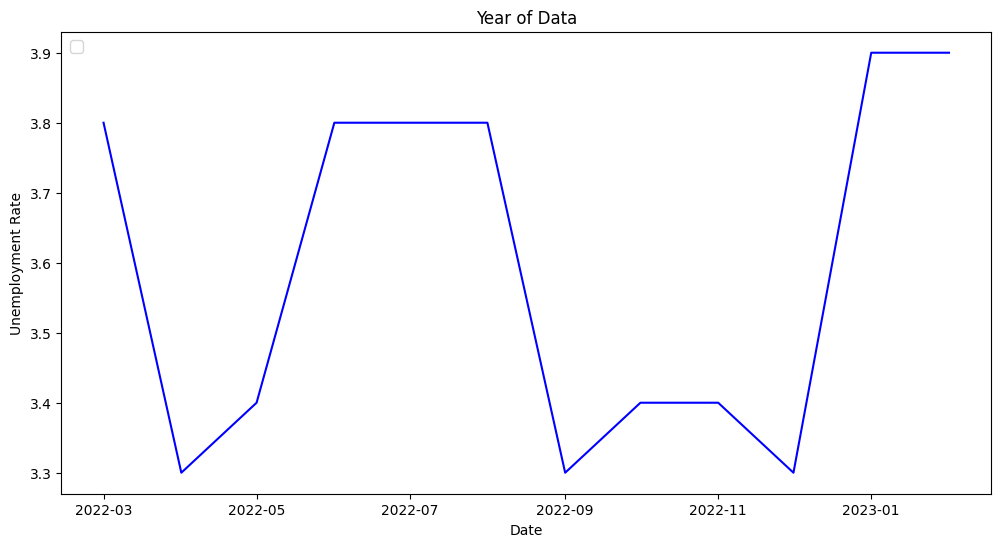

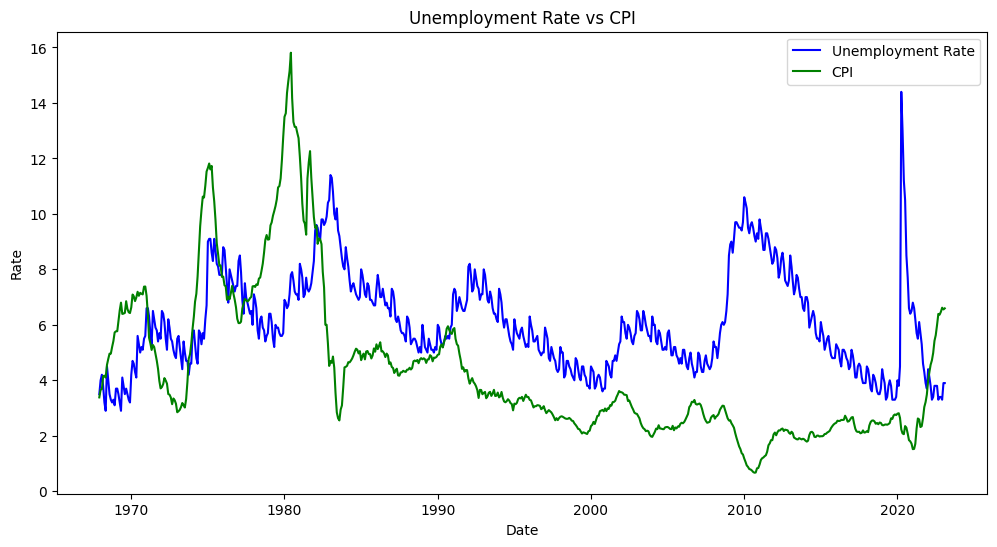

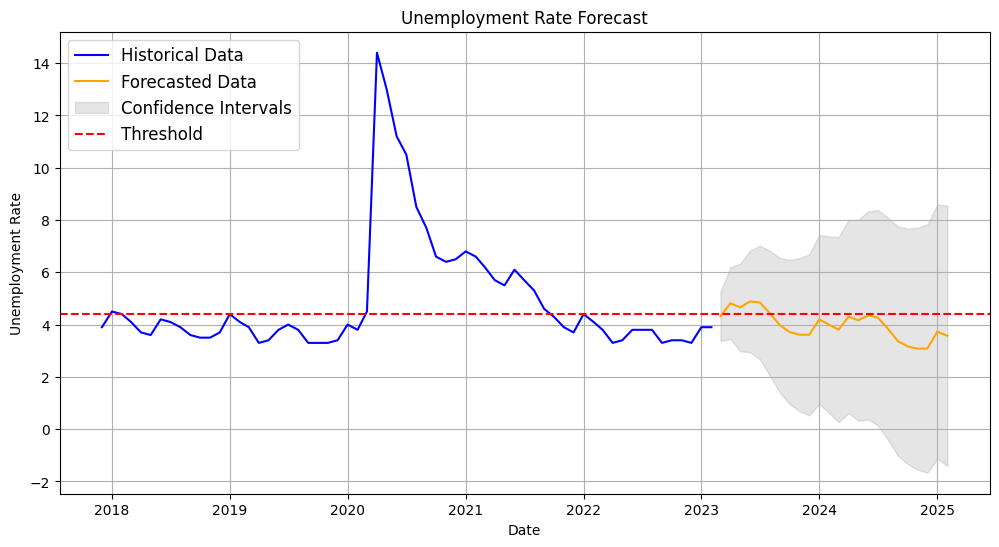

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Load the data
cpi_data = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1318&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=CORESTICKM159SFRBATL&scale=left&cosd=1967-12-01&coed=2023-02-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2023-04-10&revision_date=2023-04-10&nd=1967-12-01')
unemployment_data = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1318&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=UNRATENSA&scale=left&cosd=1948-01-01&coed=2023-03-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2023-04-10&revision_date=2023-04-10&nd=1948-01-01')

# Define functions for data preprocessing and model fitting
def preprocess_data(cpi_data, unemployment_data):
    """
    Preprocesses the job openings and unemployment data by converting the DATE column to datetime,
    dropping any rows with missing values, and converting the relevant columns to numeric.
    """
    cpi_data['DATE'] = pd.to_datetime(cpi_data['DATE'])
    cpi_data = cpi_data.dropna()
    cpi_data['CORESTICKM159SFRBATL'] = pd.to_numeric(cpi_data['CORESTICKM159SFRBATL'])

    unemployment_data['DATE'] = pd.to_datetime(unemployment_data['DATE'])
    unemployment_data = unemployment_data.dropna()
    unemployment_data['UNRATENSA'] = pd.to_numeric(unemployment_data['UNRATENSA'])

    # Merge the data on DATE
    merged_data = pd.merge(cpi_data, unemployment_data, on='DATE')
    merged_data.set_index('DATE', inplace=True)

    return merged_data

def fit_arima_model(data):
    """
    Fits a SARIMAX model to the preprocessed data and returns the model fit object.
    """
    arima_model = ARIMA(data['UNRATENSA'], exog=data['CORESTICKM159SFRBATL'], order=(1,1,1), seasonal_order=(1,1,1,12))
    arima_model_fit = arima_model.fit()
    return arima_model_fit

# Preprocess the data
try:
    data = preprocess_data(cpi_data, unemployment_data)
except Exception as e:
    print(f"Error occurred while preprocessing data: {e}")

# Fit a ARIMA model to the preprocessed data
try:
    arima_model_fit = fit_arima_model(data)
except Exception as e:
    print(f"Error occurred while fitting SARIMAX model: {e}")

# Forecast future unemployment rates
forecast_steps = 24
try:
    forecast_results = arima_model_fit.get_forecast(steps=forecast_steps, exog=cpi_data['CORESTICKM159SFRBATL'][-forecast_steps:], alpha=0.05)
    unemployment_forecast = forecast_results.predicted_mean
    ci_lower = forecast_results.conf_int()['lower UNRATENSA']
    ci_upper = forecast_results.conf_int()['upper UNRATENSA']
except Exception as e:
    print(f"Error occurred while forecasting unemployment rates: {e}")

# Calculate threshold unemployment rate
threshold = unemployment_forecast.mean() * 1.1

# Determine the best time to switch jobs
if unemployment_forecast.iloc[-1] > threshold:
    switch_jobs = True
    switch_reason = "The forecasted unemployment rate ({:.2f}) is above the threshold ({:.2f}).".format(unemployment_forecast.iloc[-1], threshold)
else:
    switch_jobs = False
    switch_reason = "The forecasted unemployment rate ({:.2f}) is below the threshold ({:.2f}).".format(unemployment_forecast.iloc[-1], threshold)

print(switch_reason)

# Plot one year of data
start_date = '2022-03-01'
end_date = '2023-03-01'

plt.figure(figsize=(12,6))
plt.plot(data[start_date:end_date].index, data[start_date:end_date]['UNRATENSA'], color='blue', linestyle='-', label='')

plt.title('Year of Data')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend(loc='upper left', fontsize='large')
plt.show()


# Plot unemployment rate vs CPI
plt.figure(figsize=(12,6))
plt.plot(data['UNRATENSA'], color='blue', linestyle='-', label='Unemployment Rate')
plt.plot(data['CORESTICKM159SFRBATL'], color='green', linestyle='-', label='CPI')
plt.title('Unemployment Rate vs CPI')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.show()

# Extend the date range for the forecasted data
forecast_dates = pd.date_range(start=unemployment_data['DATE'].iloc[-2], periods=forecast_steps+1, freq='MS')[1:]

plt.figure(figsize=(12,6))
plt.plot(data.index[600:], data['UNRATENSA'][600:], color='blue', linestyle='-', label='Historical Data')
plt.plot(forecast_dates, unemployment_forecast, color='orange', linestyle='-', label='Forecasted Data')
plt.fill_between(ci_lower.index, ci_lower, ci_upper, alpha=0.2, color='gray', label='Confidence Intervals')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.grid(True)
plt.title('Unemployment Rate Forecast')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend(loc='upper left', fontsize='large')
plt.show()